In [1]:
import pandas as pd

# Charger les trois fichiers
train = pd.read_csv("/kaggle/input/govreport-urban-data/govreport_urban_train.csv")
val   = pd.read_csv("/kaggle/input/govreport-urban-data/govreport_urban_val.csv")
test  = pd.read_csv("/kaggle/input/govreport-urban-data/govreport_urban_test.csv")

# Fonction utilitaire pour calculer min, max, moyenne
def stats_words(df, name):
    report_lengths = df['report'].astype(str).apply(lambda x: len(x.split()))
    summary_lengths = df['summary'].astype(str).apply(lambda x: len(x.split()))
    
    print(f"\n===== {name} ==========")
    print("# Nombre de lignes :", len(df))
    for i, row in df.head(5).iterrows():
        report_words = len(str(row['report']).split())
        summary_words = len(str(row['summary']).split())
        print(f"Ligne {i}: report={report_words} mots, summary={summary_words} mots")
    print("# Report -> min:", report_lengths.min(), 
          "max:", report_lengths.max(), 
          "moyenne:", round(report_lengths.mean(), 2))
    print("# Summary -> min:", summary_lengths.min(), 
          "max:", summary_lengths.max(), 
          "moyenne:", round(summary_lengths.mean(), 2))

# Calculer pour chaque dataset
stats_words(train, "Train")
stats_words(val, "Validation")
stats_words(test, "Test")


===== Train ==========
# Nombre de lignes : 8865
Ligne 0: report=11002 mots, summary=520 mots
Ligne 1: report=16466 mots, summary=669 mots
Ligne 2: report=5391 mots, summary=453 mots
Ligne 3: report=11605 mots, summary=429 mots
Ligne 4: report=16676 mots, summary=614 mots
# Report -> min: 173 max: 181328 moyenne: 7966.74
# Summary -> min: 20 max: 1890 moyenne: 495.25

===== Validation ==========
# Nombre de lignes : 493
Ligne 0: report=6088 mots, summary=468 mots
Ligne 1: report=5517 mots, summary=410 mots
Ligne 2: report=7407 mots, summary=354 mots
Ligne 3: report=7477 mots, summary=575 mots
Ligne 4: report=288 mots, summary=100 mots
# Report -> min: 288 max: 37242 moyenne: 7906.97
# Summary -> min: 78 max: 1102 moyenne: 492.95

===== Test ==========
# Nombre de lignes : 493
Ligne 0: report=7507 mots, summary=679 mots
Ligne 1: report=9496 mots, summary=411 mots
Ligne 2: report=14036 mots, summary=393 mots
Ligne 3: report=11162 mots, summary=669 mots
Ligne 4: report=5683 mots, summary

In [2]:
# Cell 1 - Install required packages
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:512"

!pip install -q transformers datasets accelerate evaluate rouge_score nltk py7zr peft bitsandbytes sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.2/494.2 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 12.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.49.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.5 which is incompatible.


In [4]:
# Cell 2 - Imports and device setup
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

import torch
import gc
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import DataCollatorForSeq2Seq, EarlyStoppingCallback
from datasets import Dataset, DatasetDict
import evaluate
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re

from peft import LoraConfig, get_peft_model, TaskType

# Check GPU and memory
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device in use: {device}")
!nvidia-smi

Device in use: cuda
Fri Feb  6 17:34:19 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8             10W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------------

In [6]:
# Cell 3 - Load and filter datasets
train_df = pd.read_csv("/kaggle/input/govreport-urban-data/govreport_urban_train.csv")
val_df = pd.read_csv("/kaggle/input/govreport-urban-data/govreport_urban_val.csv")
test_df = pd.read_csv("/kaggle/input/govreport-urban-data/govreport_urban_test.csv")

def filter_by_length(df, min_words=100, max_words=10000):
    word_counts = df['report'].str.split().str.len()
    mask = word_counts.between(min_words, max_words)
    filtered_df = df[mask].copy()
    removed = len(df) - len(filtered_df)
    print(f"Filtered {len(df)} -> {len(filtered_df)} examples (removed {removed})")
    return filtered_df

print("Training set:")
train_filtered = filter_by_length(train_df)

print("\nValidation set:")
val_filtered = filter_by_length(val_df)

print("\nTest set:")
test_filtered = filter_by_length(test_df)

raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(train_filtered),
    "validation": Dataset.from_pandas(val_filtered),
    "test": Dataset.from_pandas(test_filtered)
})

print(f"\nFinal sizes - Train: {len(raw_datasets['train'])}, Val: {len(raw_datasets['validation'])}, Test: {len(raw_datasets['test'])}")

Training set:
Filtered 8865 -> 6611 examples (removed 2254)

Validation set:
Filtered 493 -> 363 examples (removed 130)

Test set:
Filtered 493 -> 366 examples (removed 127)

Final sizes - Train: 6611, Val: 363, Test: 366


In [7]:
# Cell 4 - Tokenizer setup with OOM-safe parameters
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# OOM-safe parameters
MAX_INPUT_LENGTH = 768
MAX_TARGET_LENGTH = 256
CHUNK_SIZE = 384
CHUNK_OVERLAP = 64

print(f"Tokenization parameters:")
print(f"Max input length: {MAX_INPUT_LENGTH}")
print(f"Max target length: {MAX_TARGET_LENGTH}")
print(f"Chunk size: {CHUNK_SIZE}, Overlap: {CHUNK_OVERLAP}")

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Tokenization parameters:
Max input length: 768
Max target length: 256
Chunk size: 384, Overlap: 64


In [8]:
# Cell 5 - Preprocessing function
def preprocess_function_bart(examples):
    reports = examples["report"]
    summaries = examples["summary"]
    
    inputs = []
    targets = []
    
    for report, summary in zip(reports, summaries):
        report_tokens = tokenizer(report, add_special_tokens=False, truncation=False)["input_ids"]
        
        if len(report_tokens) <= MAX_INPUT_LENGTH - 10:
            inputs.append(report)
            targets.append(summary)
        else:
            chunks = []
            step = CHUNK_SIZE - CHUNK_OVERLAP
            
            for i in range(0, len(report_tokens), step):
                chunk_tokens = report_tokens[i:i + CHUNK_SIZE]
                chunks.append(chunk_tokens)
                if i + CHUNK_SIZE >= len(report_tokens):
                    break
            
            if len(chunks) >= 2:
                combined_tokens = chunks[0] + chunks[1]
                if len(combined_tokens) > MAX_INPUT_LENGTH - 10:
                    combined_tokens = combined_tokens[:MAX_INPUT_LENGTH-10]
                combined_text = tokenizer.decode(combined_tokens, skip_special_tokens=True)
                inputs.append(combined_text)
            else:
                chunk_text = tokenizer.decode(chunks[0], skip_special_tokens=True)
                inputs.append(chunk_text)
            
            targets.append(summary)
    
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding="max_length"
    )
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            text_target=targets,
            max_length=MAX_TARGET_LENGTH,
            truncation=True,
            padding="max_length"
        )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(
    preprocess_function_bart,
    batched=True,
    batch_size=64,
    remove_columns=raw_datasets["train"].column_names,
    desc="Tokenizing"
)

print("Tokenization complete")
print(tokenized_datasets)

Tokenizing:   0%|          | 0/6611 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Tokenizing:   0%|          | 0/363 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/366 [00:00<?, ? examples/s]

Tokenization complete
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6611
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 363
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 366
    })
})


In [9]:
# Cell 6 - Token length statistics
def show_token_stats(split, name):
    input_ids = torch.tensor(split['input_ids'])
    labels = torch.tensor(split['labels'])
    pad_token = tokenizer.pad_token_id
    
    input_lengths = (input_ids != pad_token).sum(dim=1).float()
    target_lengths = (labels != pad_token).sum(dim=1).float()
    
    print(f"\n===== {name} =====")
    print(f"Examples: {len(split)}")
    
    for i in range(min(3, len(split))):
        print(f"  Example {i}: input={int(input_lengths[i])} tokens, target={int(target_lengths[i])} tokens")
    
    print(f"Input: min={int(input_lengths.min())}, max={int(input_lengths.max())}, mean={input_lengths.mean():.1f}")
    print(f"Target: min={int(target_lengths.min())}, max={int(target_lengths.max())}, mean={target_lengths.mean():.1f}")

show_token_stats(tokenized_datasets['train'], "Train")
show_token_stats(tokenized_datasets['validation'], "Validation")
show_token_stats(tokenized_datasets['test'], "Test")


===== Train =====
Examples: 6611
  Example 0: input=760 tokens, target=256 tokens
  Example 1: input=760 tokens, target=256 tokens
  Example 2: input=760 tokens, target=256 tokens
Input: min=237, max=763, mean=759.5
Target: min=26, max=256, mean=250.5

===== Validation =====
Examples: 363
  Example 0: input=760 tokens, target=256 tokens
  Example 1: input=760 tokens, target=256 tokens
  Example 2: input=760 tokens, target=256 tokens
Input: min=374, max=760, mean=758.2
Target: min=101, max=256, mean=250.6

===== Test =====
Examples: 366
  Example 0: input=760 tokens, target=256 tokens
  Example 1: input=760 tokens, target=256 tokens
  Example 2: input=760 tokens, target=256 tokens
Input: min=759, max=762, mean=760.0
Target: min=83, max=256, mean=251.9


In [10]:
# Cell 7 - Model loading with OOM optimizations
torch.cuda.empty_cache()
gc.collect()

print("Loading BART model with memory optimizations...")

model = BartForConditionalGeneration.from_pretrained(
    "facebook/bart-base",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
)

model.gradient_checkpointing_enable()
model.config.use_cache = False

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj", "out_proj", "fc1", "fc2"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

model.enable_input_require_grads()
model = model.to(device)

if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated() / 1024**3
    reserved = torch.cuda.memory_reserved() / 1024**3
    print(f"Memory allocated: {allocated:.2f} GB")
    print(f"Memory reserved: {reserved:.2f} GB")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading BART model with memory optimizations...


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

trainable params: 1,622,016 || all params: 141,042,432 || trainable%: 1.1500
Memory allocated: 0.27 GB
Memory reserved: 0.28 GB


In [17]:
# Cell 8 - Evaluation metrics setup
import numpy as np

rouge = evaluate.load('rouge')
bleu = evaluate.load('bleu')
meteor = evaluate.load('meteor')

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    
    if isinstance(preds, tuple):
        preds = preds[0]
    
    if hasattr(preds, 'cpu'):
        preds = preds.cpu().numpy()
    if hasattr(labels, 'cpu'):
        labels = labels.cpu().numpy()
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # Filter out any None values or invalid token IDs
    preds = np.array(preds, dtype=np.int64)
    labels = np.array(labels, dtype=np.int64)
    
    vocab_size = tokenizer.vocab_size
    preds = np.clip(preds, 0, vocab_size - 1)
    labels = np.clip(labels, 0, vocab_size - 1)
    
    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Clean up any None or empty strings that might slip through
    decoded_preds = [str(p) if p is not None else "" for p in decoded_preds]
    decoded_labels = [str(l) if l is not None else "" for l in decoded_labels]
    
    # Compute metrics
    rouge_result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
        use_aggregator=True
    )
    
    # BLEU expects list of references for each prediction
    bleu_result = bleu.compute(
        predictions=decoded_preds,
        references=[[ref] for ref in decoded_labels]
    )
    
    meteor_result = meteor.compute(
        predictions=decoded_preds,
        references=decoded_labels
    )
    
    # Calculate generation lengths
    gen_lengths = [np.count_nonzero(p != tokenizer.pad_token_id) for p in preds]
    
    scores = {
        'rouge1': rouge_result['rouge1'],
        'rouge2': rouge_result['rouge2'],
        'rougeL': rouge_result['rougeL'],
        'rougeLsum': rouge_result['rougeLsum'],
        'bleu': bleu_result['bleu'],
        'meteor': meteor_result['meteor'],
        'gen_len': np.mean(gen_lengths)
    }
    
    return {k: round(v, 4) for k, v in scores.items()}

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
# Cell 9 - OOM-safe training configuration
import numpy as np
import torch

num_gpus = torch.cuda.device_count()
print(f"GPUs available: {num_gpus}")
if num_gpus > 0:
    for i in range(num_gpus):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")

# OOM-safe batch sizes for Tesla T4 (16GB)
train_batch_size = 2
eval_batch_size = 1
grad_accum_steps = 4

model.enable_input_require_grads()

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=-100,
    pad_to_multiple_of=8,
    return_tensors="pt"
)

training_args = Seq2SeqTrainingArguments(
    output_dir="./bart-lora-govreport",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,
    
    # OOM-critical settings
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=eval_batch_size,
    gradient_accumulation_steps=grad_accum_steps,
    
    weight_decay=0.01,
    num_train_epochs=4,
    
    # Generation settings for ROUGE evaluation
    predict_with_generate=True,
    generation_max_length=256,
    generation_num_beams=2,
    
    # --- MEMORY OPTIMIZATIONS & GRADIENT FIX ---
    fp16=True,
    fp16_full_eval=True,
    gradient_checkpointing=True,
    # This line solves the "element 0 of tensors does not require grad" error
    gradient_checkpointing_kwargs={"use_reentrant": False}, 
    
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    
    # Early stopping and model selection
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    greater_is_better=True,
    save_total_limit=2,
    
    # Logging
    report_to="tensorboard",
    logging_dir="./logs",
    logging_steps=10,
    logging_first_step=True,
    
    # Modern Optimizer
    optim="adamw_torch_fused",
    max_grad_norm=1.0,
    warmup_ratio=0.1,
    
    # Evaluation memory management
    eval_accumulation_steps=2,
    disable_tqdm=False,
)

# Final memory check
if torch.cuda.is_available():
    print(f"\nMemory status before training:")
    print(f"Allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"Reserved: {torch.cuda.memory_reserved()/1024**3:.2f} GB")

# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    processing_class=tokenizer, 
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Display effective batch size info
effective_batch = train_batch_size * max(1, num_gpus) * grad_accum_steps
print(f"\nTraining configuration:")
print(f"Total effective batch: {effective_batch}")
print(f"Steps per epoch: {len(tokenized_datasets['train']) // effective_batch}")

print("\n" + "="*60)
print("Starting training...")
print("="*60 + "\n")

# Run training
trainer.train()

GPUs available: 2
  GPU 0: Tesla T4
  GPU 1: Tesla T4

Memory status before training:
Allocated: 0.31 GB
Reserved: 0.34 GB

Training configuration:
Total effective batch: 16
Steps per epoch: 413

Starting training...



/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Meteor,Gen Len
1,2.499600,2.320312,0.465400,0.175100,0.248200,0.248000,0.165200,0.307200,249.931100
2,2.577700,2.310547,0.465800,0.174300,0.248500,0.248400,0.163000,0.308000,250.630900
3,2.476600,2.296875,0.471100,0.177000,0.249700,0.249600,0.167200,0.311400,250.732800
4,2.481000,2.291016,0.469000,0.174800,0.249000,0.248800,0.164200,0.308100,250.052300


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1656, training_loss=2.504738185716712, metrics={'train_runtime': 6226.503, 'train_samples_per_second': 4.247, 'train_steps_per_second': 0.266, 'total_flos': 1.2290552236081152e+16, 'train_loss': 2.504738185716712, 'epoch': 4.0})

In [19]:
# Cell 10 - Save model
output_path = "./bart-lora-govreport-final"
trainer.save_model(output_path)
tokenizer.save_pretrained(output_path)
lora_config.save_pretrained(output_path)

print(f"Model saved to {output_path}")
torch.cuda.empty_cache()

Model saved to ./bart-lora-govreport-final


In [20]:
# Cell 11 - Test evaluation
print("Evaluating on test set...")

test_metrics = trainer.evaluate(
    tokenized_datasets["test"], 
    metric_key_prefix="test",
    max_length=256,
    num_beams=2
)

print("\nTest results:")
for key, value in test_metrics.items():
    if "test_" in key and "loss" not in key and "runtime" not in key:
        clean_key = key.replace("test_", "")
        print(f"{clean_key:15} : {value:.4f}")

Evaluating on test set...


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


early stopping required metric_for_best_model, but did not find eval_rougeL so early stopping is disabled



Test results:
rouge1          : 0.4646
rouge2          : 0.1682
rougeL          : 0.2432
rougeLsum       : 0.2431
bleu            : 0.1576
meteor          : 0.3073
gen_len         : 251.4781
samples_per_second : 0.4280
steps_per_second : 0.2140


In [21]:
# Cell 12 - Generate example summaries
def generate_summaries(texts, batch_size=1):
    summaries = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            max_length=MAX_INPUT_LENGTH,
            truncation=True,
            padding=True
        ).to(device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=256,
                min_length=50,
                num_beams=2,
                length_penalty=2.0,
                early_stopping=True,
                no_repeat_ngram_size=3,
                do_sample=False
            )
        
        batch_summaries = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        summaries.extend(batch_summaries)
        
        torch.cuda.empty_cache()
    
    return summaries

print("="*70)
print("SUMMARY EXAMPLES")
print("="*70)

num_examples = 2
test_samples = []

for i in range(num_examples):
    sample = raw_datasets['test'][i]
    test_samples.append(sample)

test_texts = [s['report'] for s in test_samples]
test_golds = [s['summary'] for s in test_samples]

import time
start = time.time()
predictions = generate_summaries(test_texts, batch_size=1)
end = time.time()

for i, (sample, pred, gold) in enumerate(zip(test_samples, predictions, test_golds), 1):
    report = sample['report']
    
    print(f"\nExample {i}")
    print("-"*50)
    print(f"Report length: {len(report.split())} words")
    
    print(f"\nReference summary:")
    print(gold[:300] + "..." if len(gold) > 300 else gold)
    
    print(f"\nGenerated summary:")
    print(pred[:300] + "..." if len(pred) > 300 else pred)
    
    pred_words = len(pred.split())
    gold_words = len(gold.split())
    print(f"\nMetrics: pred={pred_words} words, ref={gold_words} words, ratio={pred_words/gold_words:.2f}")

print(f"\nInference time: {end-start:.2f} seconds")
print(f"Average: {(end-start)/num_examples:.2f} seconds per example")

SUMMARY EXAMPLES

Example 1
--------------------------------------------------
Report length: 7507 words

Reference summary:
Access to broadband Internet is seen as being crucial to improving access to information, quality of life, and economic growth. In recent years, some Internet providers have moved away from unlimited data plans to UBP with uncertain effects on consumers. GAO was asked to review the use of UBP by Int...

Generated summary:
The Federal Communications Commission (FCC) is responsible for overseeing broadband Internet access. In recent years, the FCC has increased the number of mobile users who subscribe to broadband Internet in two ways: Mobile: Traditionally, mobile providers sold access to the Internet as an add-on to ...

Metrics: pred=209 words, ref=679 words, ratio=0.31

Example 2
--------------------------------------------------
Report length: 9496 words

Reference summary:
In 1996 and 1999, Congress authorized the U.S. Army Corps of Engineers (the Corps) to s

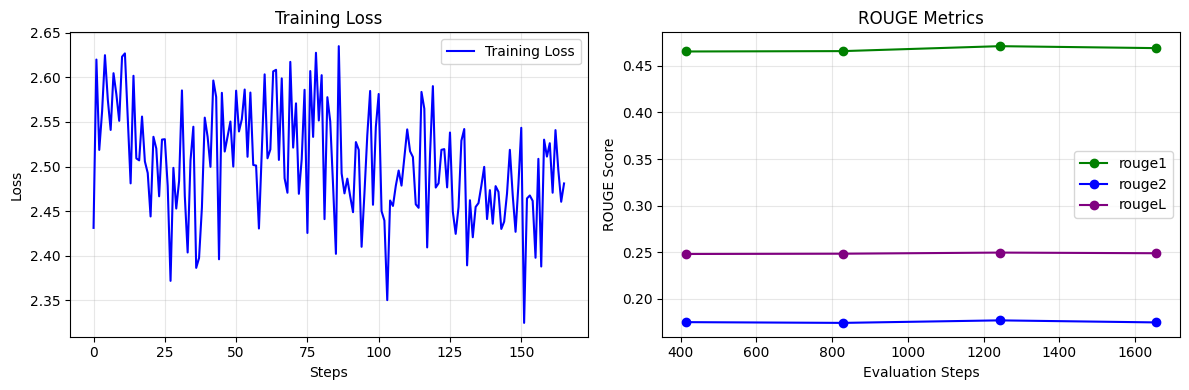


Final training summary:
rouge1    : 0.4646
rouge2    : 0.1682
rougeL    : 0.2432
bleu      : 0.1576
meteor    : 0.3073
Train size: 6611
Test size : 366


In [22]:
# Cell 13 - Visualize results
import matplotlib.pyplot as plt
import numpy as np

history = trainer.state.log_history

train_logs = [log for log in history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in history if 'eval_loss' in log]

plt.figure(figsize=(12, 4))

if train_logs:
    plt.subplot(1, 2, 1)
    train_loss = [log['loss'] for log in train_logs]
    train_steps = list(range(len(train_loss)))
    plt.plot(train_steps, train_loss, 'b-', label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()

if eval_logs:
    plt.subplot(1, 2, 2)
    rouge_metrics = ['eval_rouge1', 'eval_rouge2', 'eval_rougeL']
    colors = ['green', 'blue', 'purple']
    
    for metric, color in zip(rouge_metrics, colors):
        if metric in eval_logs[0]:
            values = [log[metric] for log in eval_logs if metric in log]
            steps = [log['step'] for log in eval_logs if metric in log]
            if values and steps:
                plt.plot(steps, values, 'o-', color=color, label=metric.replace('eval_', ''))
    
    plt.xlabel('Evaluation Steps')
    plt.ylabel('ROUGE Score')
    plt.title('ROUGE Metrics')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.savefig('training_results.png', dpi=100)
plt.show()

print("\nFinal training summary:")
print("="*50)
if test_metrics:
    for key in ['test_rouge1', 'test_rouge2', 'test_rougeL', 'test_bleu', 'test_meteor']:
        if key in test_metrics:
            print(f"{key.replace('test_', ''):10}: {test_metrics[key]:.4f}")
print(f"{'Train size':10}: {len(tokenized_datasets['train'])}")
print(f"{'Test size':10}: {len(tokenized_datasets['test'])}")
print("="*50)